### Modules used in this notebook
`pypsa`, `plotnine`
The notebook also requires a solver (e.g. `Cbc` or GLPK)

## E.001: Creating your first power system model
In this notebook you will create a simple power system model simulating a system with specific month of the year using wind and solar profiles based on atmospheric reanalysis data. The model will be optimised to define the optimal capacity of batteries needed to balance the system.

The used model is PyPSA: [an open-source power system model](https://pypsa.org/)

# Step 02: Load wind, solar, demand data
We use a set of Parquet files containing the electricity demand, wind and solar profiles based on [this dataset](https://researchdata.reading.ac.uk/272/) developed by Bloomfield et al., University of Reading.

The Parquet files provide a data frame with the hourly values for all the European countries for the years 2000-2019 (the original dataset goes back to 1979 but we have kept only the last 20 years to reduce the amount of storage needed to run this notebook).

In [1]:
import pandas as pd
dem = pd.read_parquet('../data/ERA5_full_demand_all_countries_2000_2019_hourly.parquet')
pv  = pd.read_parquet('../data/ERA5_solar_power_capacity_factor_all_countries_2000_2019_hourly.parquet')
win = pd.read_parquet('../data/ERA5_wind_power_capacity_factor_all_countries_2000_2019_inclusive.parquet')
dem.head()

,datetime,Austria,Belgium,Bulgaria,Croatia,Czech_Republic,Denmark,Finland,France,Germany,...,Norway,Poland,Portugal,Romania,Slovakia,Slovenia,Spain,Sweden,Switzerland,United_Kingdom
0,2000-01-01 00:00:00+00:00,6.149653,8.547436,4.288882,1.557109,6.583412,2.543370,10.218680,56.496736,40.287049,...,15.602364,15.173096,5.161892,6.074548,3.032983,1.177564,23.342019,16.258756,6.420162,31.481235
1,2000-01-01 01:00:00+00:00,6.005393,8.184474,4.241575,1.474065,6.535270,2.489337,10.133998,55.007324,39.336272,...,15.424182,14.849854,4.776771,6.029861,2.986461,1.152904,22.036881,16.147893,6.465112,29.741144
2,2000-01-01 02:00:00+00:00,5.854461,7.972377,4.265739,1.445917,6.463566,2.492441,10.185449,52.251049,39.381310,...,15.410204,14.818497,4.538195,6.085059,2.987110,1.149503,21.423310,16.162053,6.489145,27.999955
3,2000-01-01 03:00:00+00:00,5.945950,7.954598,4.407904,1.465845,6.551649,2.553254,10.472526,51.265385,40.223583,...,15.522155,15.023909,4.418843,6.265306,3.048357,1.170514,21.222722,16.324404,6.523057,27.066848
4,2000-01-01 04:00:00+00:00,6.444086,8.264821,4.780009,1.587208,6.891379,2.748628,11.128114,53.134412,42.170035,...,15.911743,15.634865,4.369596,6.687905,3.175566,1.260816,21.653859,16.956360,6.423579,26.070716


# Step 03: selecting year, month, and country
In this example we simulate a power system model consisting of a wind power farm, a solar plant and a lithium-ion battery using the electricity demand and the RES profiles (capacity factors) for a specific country and a specific month.

In [2]:
selected_year = 2012 # 2000-2019
selected_month = 2 # 1 = January, 12 = December
country = 'Spain'

In [3]:
# Select demand, solar (PV) and wind profiles
selected_dem = dem.loc[(pd.DatetimeIndex(dem['datetime']).year == selected_year) & (pd.DatetimeIndex(dem['datetime']).month == selected_month)][country]
selected_pv  = pv.loc[(pd.DatetimeIndex(pv['datetime']).year == selected_year) & (pd.DatetimeIndex(pv['datetime']).month == selected_month)][country]
selected_win = win.loc[(pd.DatetimeIndex(win['datetime']).year == selected_year) & (pd.DatetimeIndex(win['datetime']).month == selected_month)][country]

In [11]:
selected_pv[selected_pv < 0] = 0 

C:\Users\matte\AppData\Local\Temp\ipykernel_8476\3607777938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_pv[selected_pv < 0] = 0


# Step 04: Building the power system model

We create here a single-bus PyPSA network with:
  - `Wind`: A wind generator with the cost of 35 000 EUR per MW
  - `Solar`: a solar generator with the cost of 20 000 EUR per MW
  - `Battery`: a battery with 3 hours of storage with the cost of 45 000 EUR per MW. The efficiency is 90%.

The system has an electricity demand defined by the load `L1`

In [19]:
import pypsa

network = pypsa.Network(snapshots = selected_dem.index)
network.add("Bus", "B1")

network.add("Generator", "Wind",
            bus="B1",
            capital_cost = 35_000,
            p_max_pu = selected_win,
            p_nom_extendable = True,
            control="PQ")

network.add("Generator", "Solar",
            bus="B1",
            capital_cost = 20_000,
            p_max_pu = selected_pv,
            p_nom_extendable = True,
            control="PQ")

network.add("StorageUnit", "Battery",
            bus="B1",
            capital_cost = 45_000,
            efficiency_store = 0.9,
            efficiency_dispatch = 0.9,
            max_hours = 3,
            p_nom_extendable = True
            )

network.add("Load", "L1",
            bus="B1",
            p_set=selected_dem*1e3)


# Step 05: Running the model
Here we solve the linear optimal power flow defined in the PyPSA network created in the step before. We print the optimal capacities (in MW) of wind, solar and batteries found by the solver.

In [20]:
network.optimize(solver_name='glpk')

print(round( network.generators.p_nom_opt ))
print(round(network.storage_units.p_nom_opt))

Index(['B1'], dtype='object', name='Bus')
Index(['B1'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.09s
INFO:linopy.solvers:GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\matte\AppData\Local\Temp\linopy-problem-s68bui6r.lp --output
 C:\Users\matte\AppData\Local\Temp\linopy-solve-z_dxl2tc.sol
Reading problem data from 'C:\Users\matte\AppData\Local\Temp\linopy-problem-s68bui6r.lp'...
8355 rows, 3483 columns, 15680 non-zeros
44232 lines were read
GLPK Simplex Optimizer 5.0
8355 rows, 3483 columns, 15680 non-zeros
Preprocessing...
4542 rows, 3153 columns, 11537 non-zeros
Scaling...
 A: min|aij| =  5.799e-08  max|aij| =  3.000e+00  ratio =  5.173e+07
GM: min|aij| =  1.745e-01  max|aij| =  5.730e+00  ratio =  3.283e+01
EQ: min|aij| =  3.048e-02  max|aij| =  1.000e+00  ratio =  3.281e+01
Constructing initial basis...
Size of triangular part is 4542
      0: obj =   0.000000000e+00 inf

Generator
Wind     157767.0
Solar     96917.0
Name: p_nom_opt, dtype: float64
StorageUnit
Battery    121230.0
Name: p_nom_opt, dtype: float64


In [21]:
network.statistics.expanded_capacity()

component    carrier
Generator    -          254683.8
StorageUnit  -          121230.0
dtype: float64

# Step 06: Plotting the dispatching
To plot the generation of the three assets modeled in this example we need to insert the data contained in the `network` object into a Pandas data frame. This is eventually used for a plot made with [plotnine](https://plotnine.readthedocs.io/en/stable/)

In [22]:
gen_list = network.generators[['bus']].reset_index()
gen_list['type'] = gen_list['Generator'].str.split('_', expand = True).iloc[:,0]
gen = (pd.merge(
    network.generators_t.p
    .unstack()
    .reset_index(), gen_list)
       .groupby(['type', 'bus', 'snapshot'])
       .sum()
       .reset_index()
      ).rename(columns = {0: 'prod'})

sto_list = network.storage_units[['bus']].reset_index()
sto_list['type'] = sto_list['StorageUnit'].str.split('_', expand = True).iloc[:,0]
sto = (pd.merge(
    network.storage_units_t.p
    .unstack()
    .reset_index(), sto_list)
       .groupby(['type', 'bus', 'snapshot'])
       .sum().reset_index()
      ).rename(columns = {0: 'prod'})

df = pd.concat([gen, sto])
df.head()

,type,bus,snapshot,Generator,prod,StorageUnit
0,Solar,B1,105936,Solar,0.0,NaN
1,Solar,B1,105937,Solar,0.0,NaN
2,Solar,B1,105938,Solar,0.0,NaN
3,Solar,B1,105939,Solar,0.0,NaN
4,Solar,B1,105940,Solar,0.0,NaN


INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


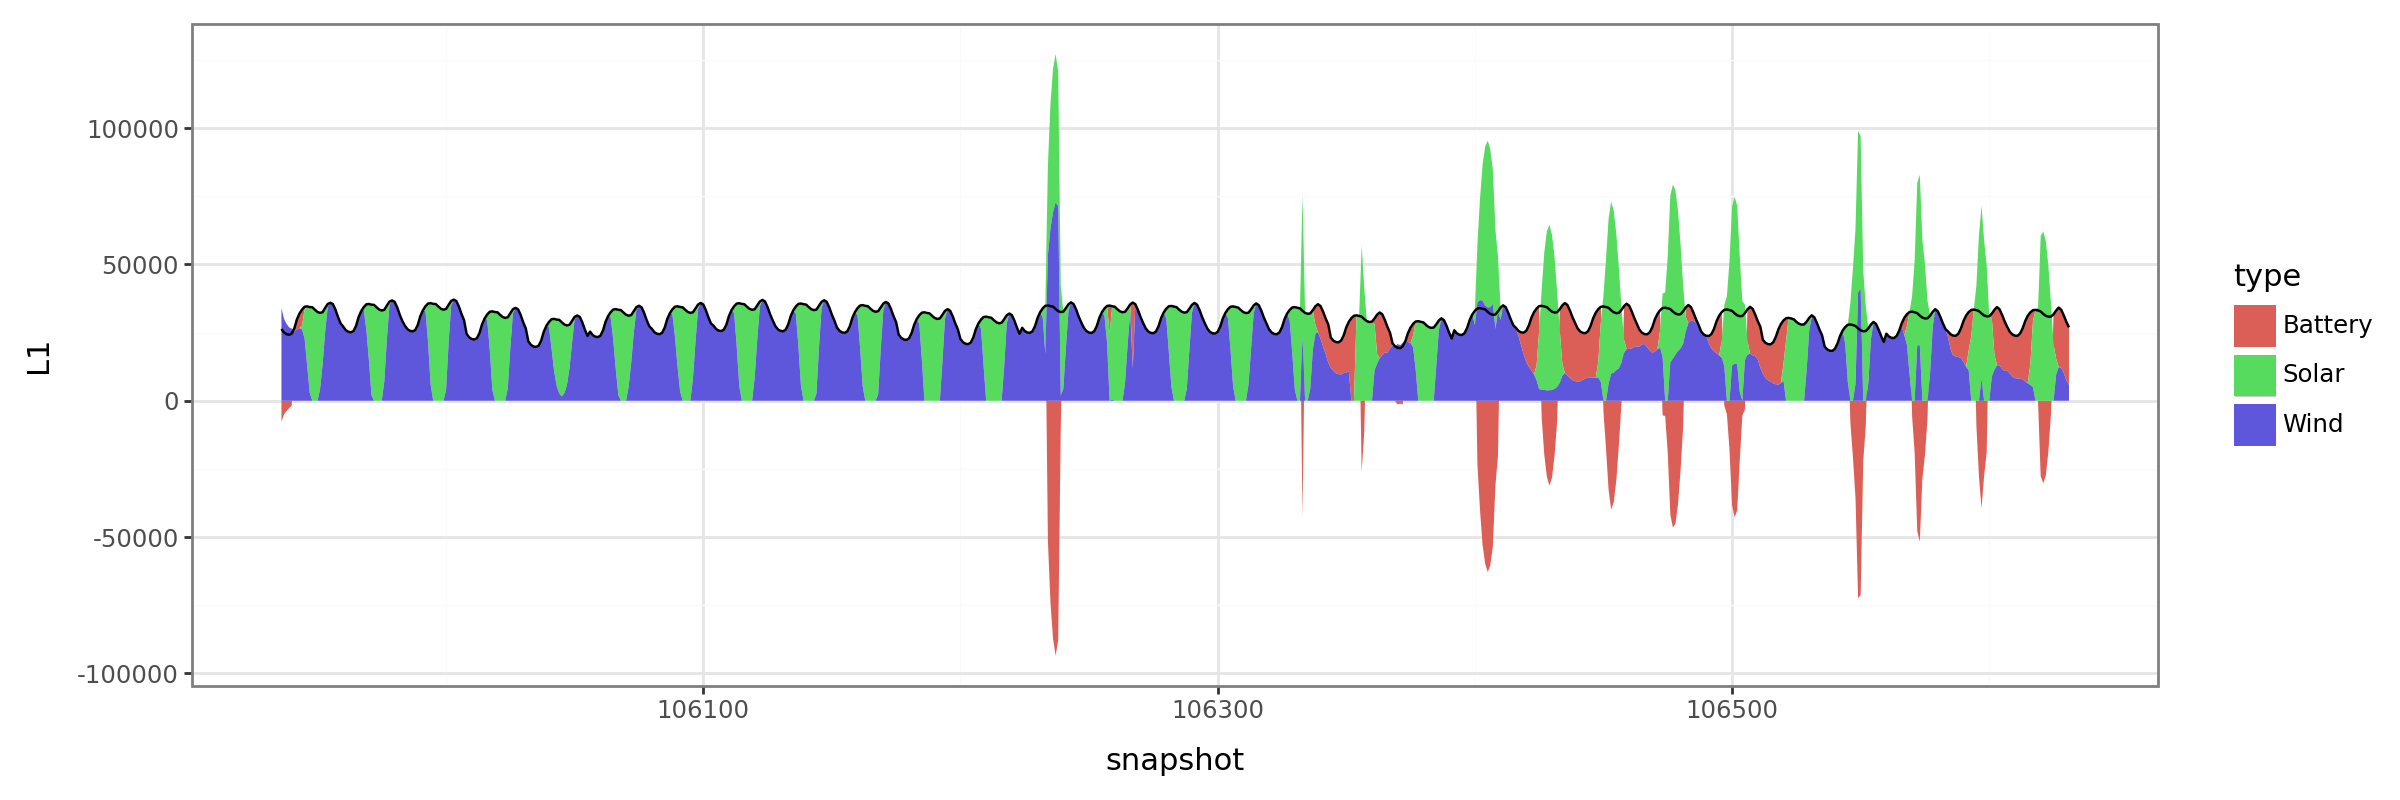

In [23]:
import plotnine
plotnine.options.figure_size = (12, 4)

(
    plotnine.ggplot(pd.DataFrame(network.loads_t.p_set.L1).reset_index(), plotnine.aes(x='snapshot', y='L1')) +
    plotnine.geom_area(plotnine.aes(x = 'snapshot', y = 'prod', fill = 'type'), data= df) +
    plotnine.geom_line() +
    plotnine.theme_bw()
)